In [1]:
from sentence_transformers import SentenceTransformer
from sklearn.cluster import KMeans
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from tqdm import tqdm
from pathlib import Path

In [5]:
transcript_dir = Path("data")
df = pd.read_csv(transcript_dir / "transcripts_normalized.csv", header=0)
df.dropna(subset=["transcript"], inplace=True)
df.head()

,video_id,transcript
0,AAHiZ-c88ec,man im getting frustrated water heater deliver...
1,AEsRr-ZnzNc,start give shout rokukun vyonder harrystack go...
2,AJpzk-aFZPU,10 minute test number exploding apple alright ...
3,AONXX-h9SdI,gonna play something brand new album came octo...
5,APerX-RLJxo,2010 toyota corolla fourdoor sedan automatic t...


In [6]:
def get_kmeans_clusters(X_embeddings: np.ndarray, n_clusters: int = 10):
    kmeans = KMeans(n_clusters=n_clusters)
    kmeans.fit(X_embeddings)
    return kmeans

In [12]:
def plot_pca(km, X_embeddings: np.ndarray, title, save=True):
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X_embeddings)
    plt.figure(figsize=(10, 5))
    plt.scatter(X_pca[:, 0], X_pca[:, 1], c=km.labels_, cmap="viridis", alpha=0.7)
    plt.colorbar(label="Label")
    plt.xlabel("PCA 1")
    plt.ylabel("PCA 2")
    plt.title(title)
    if save:
        plt.savefig(f"figures/emb_baseline_pca_{title}.png")
    plt.show()

In [7]:
cluster_sizes = list(range(10, 30))
df_all = df.copy()
df_less_than_100 = df[df["transcript"].str.split().str.len() < 100]
df_more_than_100 = df[df["transcript"].str.split().str.len() >= 100]

df_corporas = [df_all, df_less_than_100, df_more_than_100]
print(df_corporas[0].shape)
print(df_corporas[1].shape)
print(df_corporas[2].shape)

(2316, 2)
(1142, 2)
(1174, 2)


In [8]:
measures = [[], [], []]
kms = [[], [], []]

model = SentenceTransformer("sentence-transformers/all-MiniLM-L6-v2")

# save embeddings once
print("Embedding transcripts...")
df_embeddings = []
for df_corpus in tqdm(df_corporas):
    embeddings = model.encode(df_corpus["transcript"].to_list(), convert_to_numpy=True)
    df_embeddings.append(embeddings)

print("Clustering transcripts...")
for n_clusters in tqdm(cluster_sizes):
    for i, df_corpus in enumerate(df_corporas):
        km = get_kmeans_clusters(df_embeddings[i], n_clusters)
        kms[i].append(km)
        measures[i].append({
            "n_clusters": n_clusters,
            "inertia": km.inertia_,
            "silhouette_score": silhouette_score(df_embeddings[i], km.labels_),
            "davies_bouldin_score": davies_bouldin_score(df_embeddings[i], km.labels_),
            "calinski_harabasz_score": calinski_harabasz_score(df_embeddings[i], km.labels_)
        })

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling%2Fconfig.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Embedding transcripts...


100%|██████████| 3/3 [01:55<00:00, 38.39s/it]


Clustering transcripts...


  0%|          | 0/20 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
/opt/anaconda3/envs/ytb/lib/python3.10/site-packages/threadpoolctl.py:1214: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
100%|██████████| 20/20 [00:13<00:00,  1.51it/s]


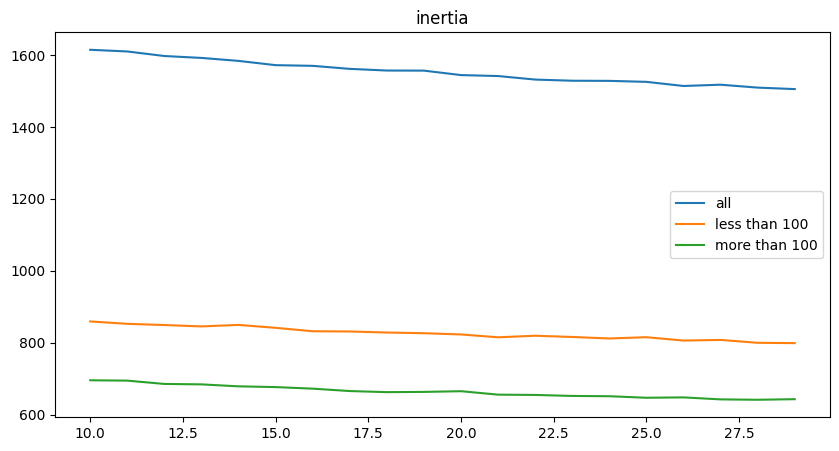

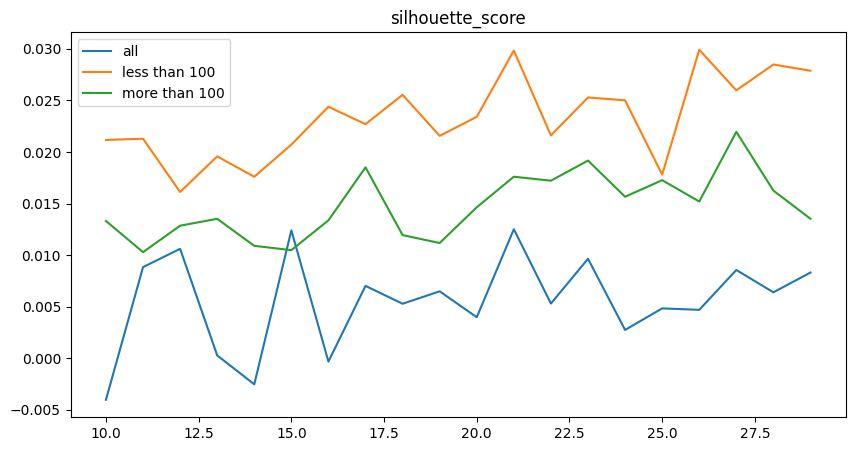

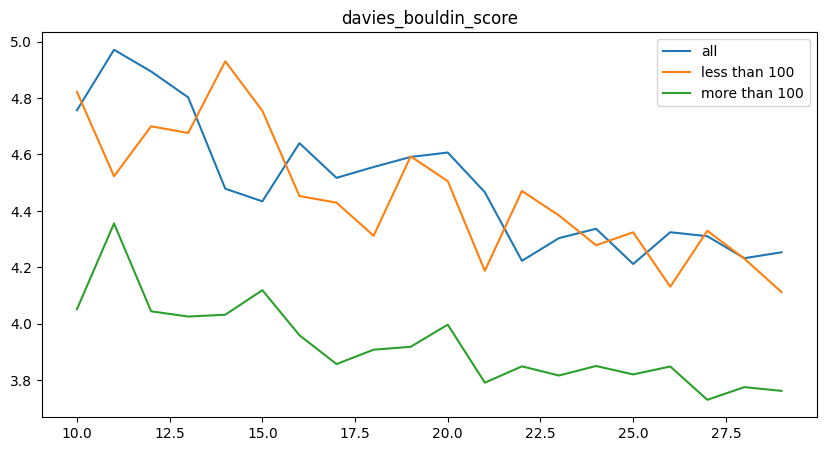

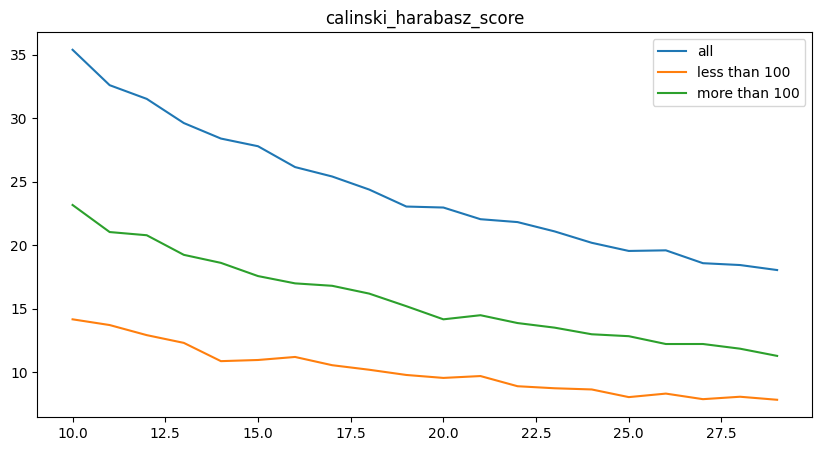

In [9]:
plot_attributes = ["inertia", "silhouette_score", "davies_bouldin_score", "calinski_harabasz_score"]
labels = ["all", "less than 100", "more than 100"]
for attribute in plot_attributes:
    plt.figure(figsize=(10, 5))
    for i, df_corpus in enumerate(df_corporas):
        plt.plot(cluster_sizes, [m[attribute] for m in measures[i]], label=labels[i])
        plt.title(attribute)
    plt.legend()
    plt.savefig(f"figures/emb_baseline_measure_{attribute}.png")
    plt.show()

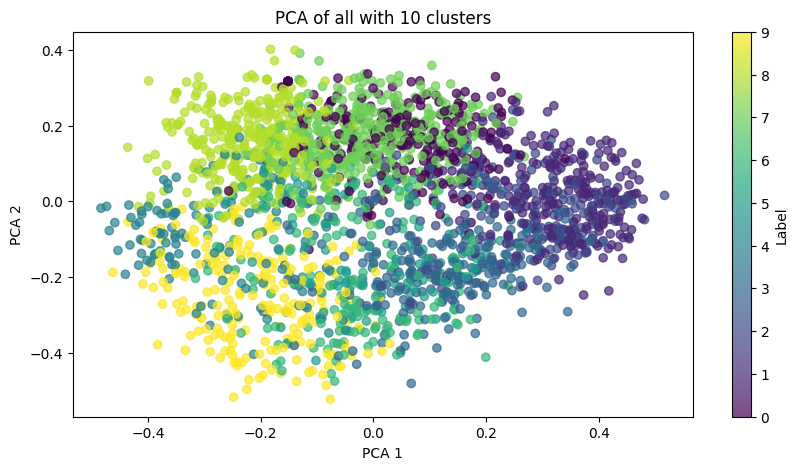

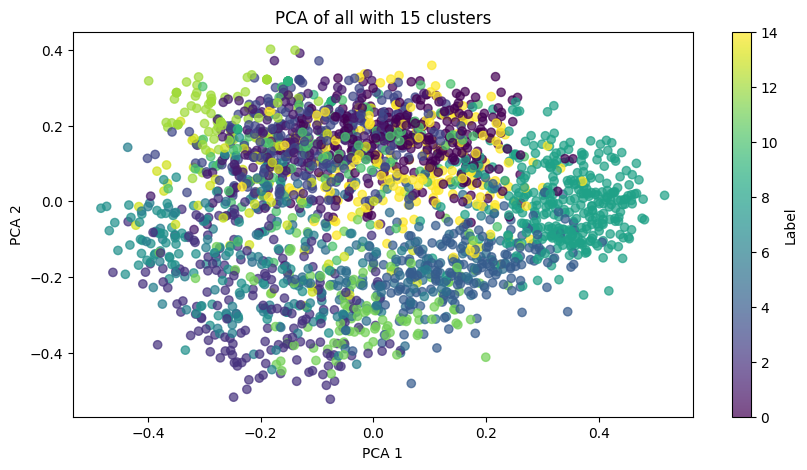

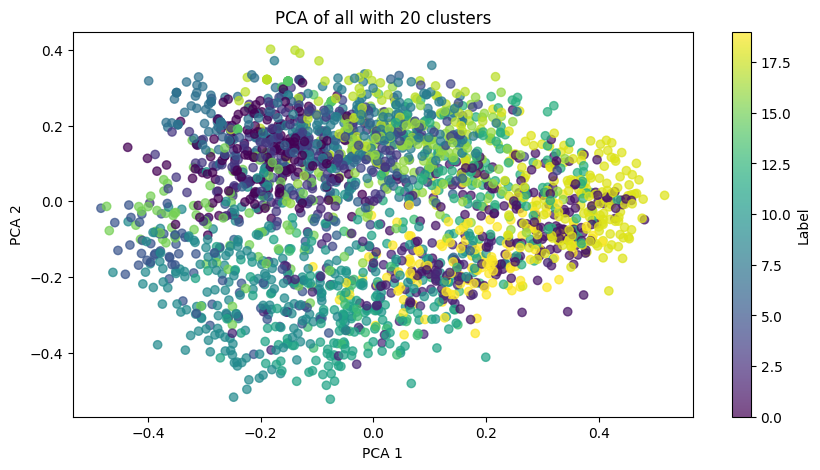

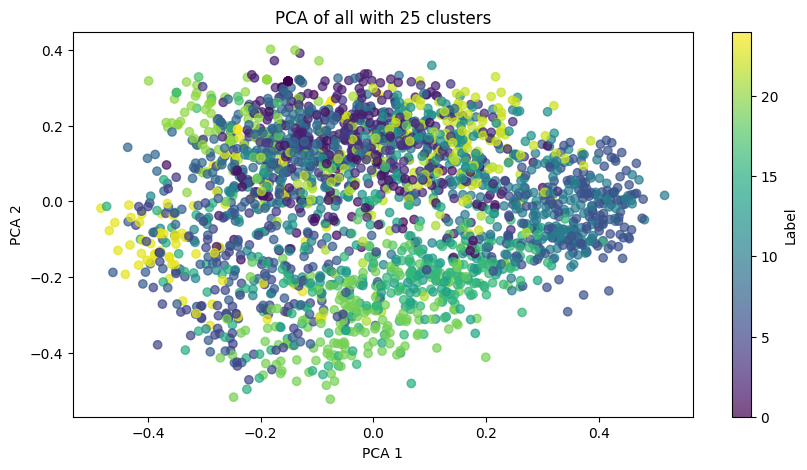

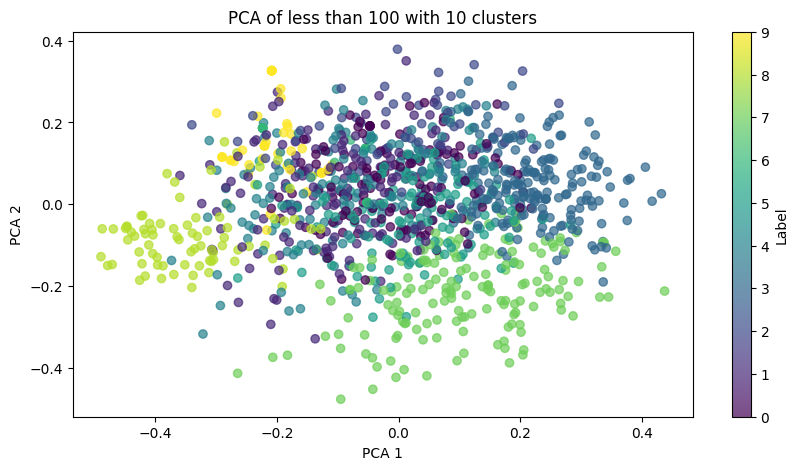

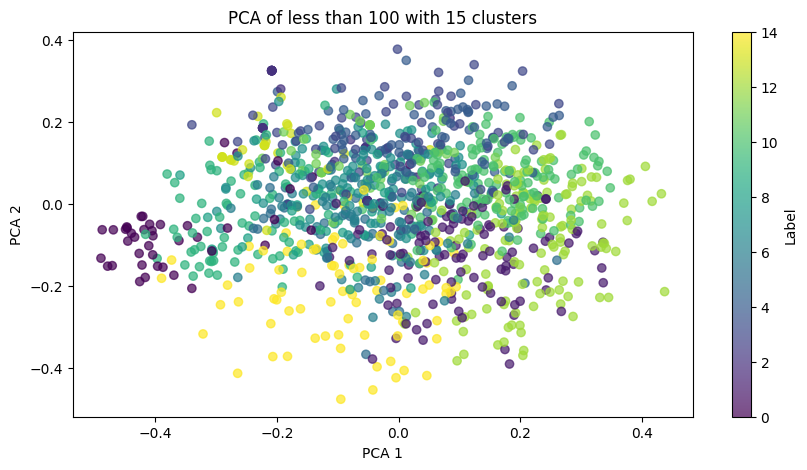

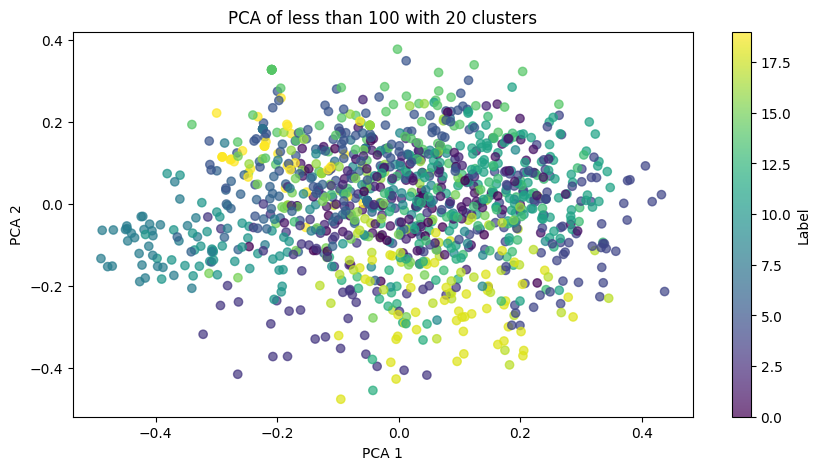

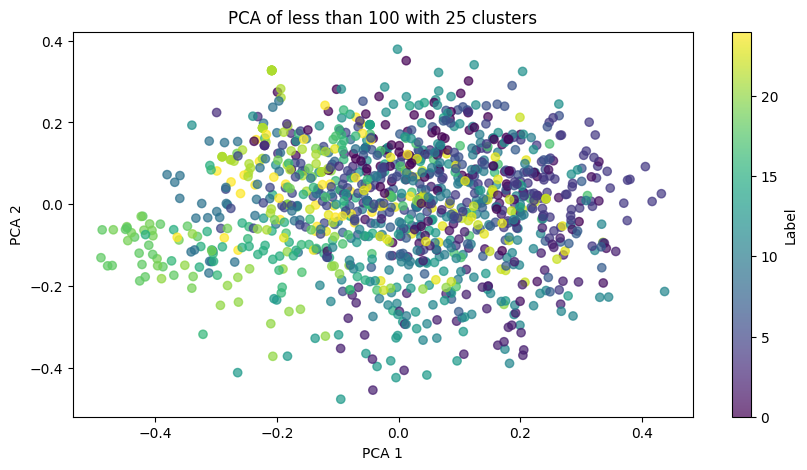

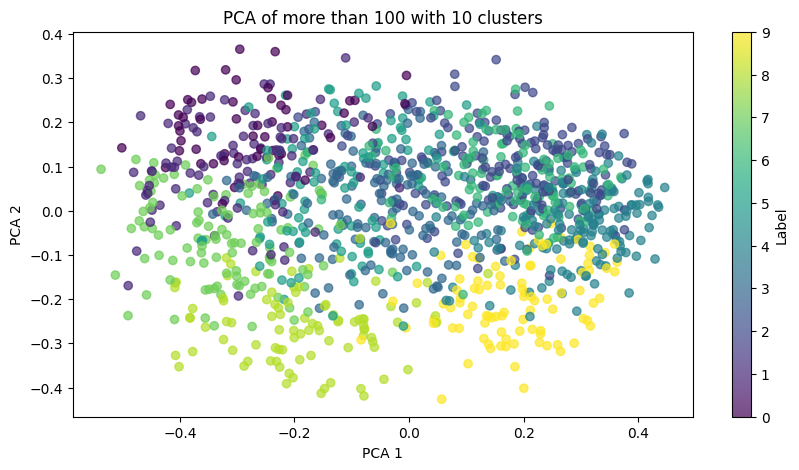

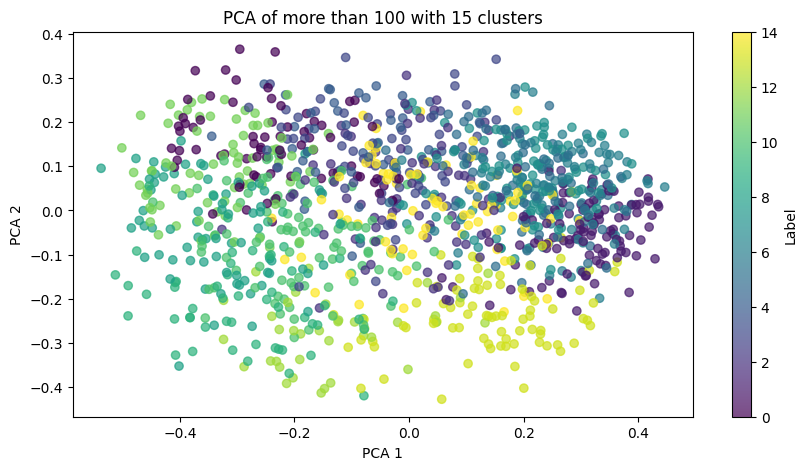

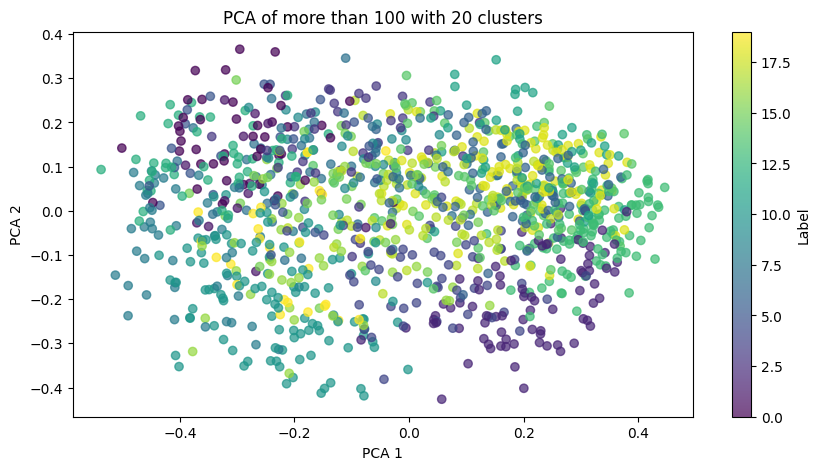

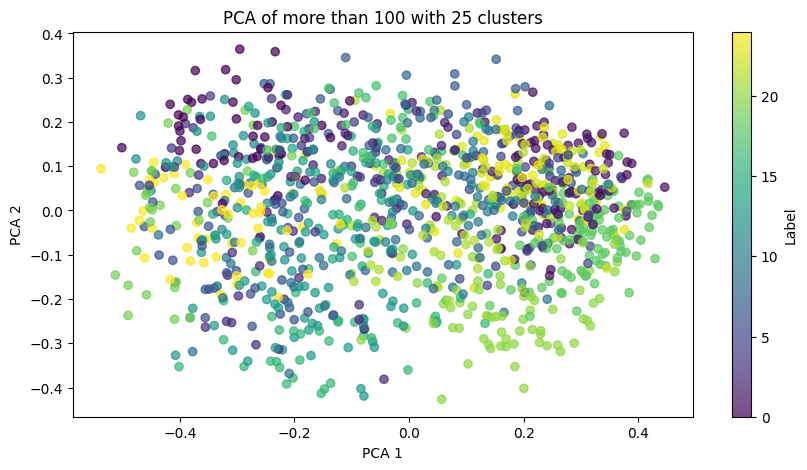

In [13]:
for i, km in enumerate(kms):
    for j, k in enumerate(km):
        if j % 5 == 0:
            plot_pca(k, df_embeddings[i], f"PCA of {labels[i]} with {cluster_sizes[j]} clusters")